In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import timedelta
from timeit import default_timer as timer
from math import sqrt

## Images reading&resizing

In [2]:
img_l = np.asanyarray(Image.open("i1.jpg").resize((400,300), Image.BICUBIC).convert("RGB")).astype(np.int)
img_r = np.asanyarray(Image.open("i2.jpg").resize((400,300), Image.BICUBIC).convert("RGB")).astype(np.int)

## Params definition

In [3]:
kg_max=45
kv_max=14
kv_half = kv_max//2
height = img_r.shape[0]
length = img_r.shape[1]

In [4]:
#import shelve

In [5]:
#with shelve.open("lab2.db") as db:
    #db["img_shift2"] = img_shift2
    #img_shift2 = db["img_shift2"]

In [6]:
#np.save("img_shift.npy", img_shift2)

In [66]:
img_shift2 = np.load("img_shift.npy")

In [67]:
from scipy import ndimage

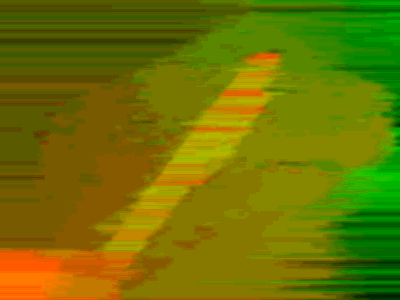

In [59]:
k = np.ones((3,3))/9
img_shift2[:,:,0] = ndimage.convolve(img_shift2[:,:,0], k, mode='reflect')
img_shift2[:,:,1] = ndimage.convolve(img_shift2[:,:,1], k, mode='reflect')
Image.fromarray((255.9*img_shift2/img_shift2.max()).astype(np.uint8))

# lab2 start

https://staff.fnwi.uva.nl/l.dorst/hz/chap11_13.pdf

In [60]:
from random import choices
from scipy.linalg import null_space

In [73]:
def is_smooth(img_shift, x, y, radius=2):
    for i in range(-radius,radius+1):
        for j in range(-radius,radius+1):
            if np.any(img_shift[y, x] != img_shift[y+i, x+j]):
                return False
    return True


map2draw = np.zeros((img_r.shape), dtype=np.uint8)

pairs = []
rejected_pairs = []
# (X, X')
for y_r in range(30, img_r.shape[0] - 30):
    for x_r in range(30, img_r.shape[1] - 30):
        x_r3d = [x_r, y_r, 1]
        
        dot_shift = img_shift2[y_r, x_r]
        
        x_l = int(x_r - dot_shift[0])
        y_l = int(y_r - (dot_shift[1] - kv_half))
        x_l3d = [x_l, y_l, 1]
        
        if is_smooth(img_shift2, x_r, y_r):
            pairs.append([x_l3d, x_r3d])
            map2draw[y_r, x_r] = 255
        else:
            rejected_pairs.append([x_l3d, x_r3d])

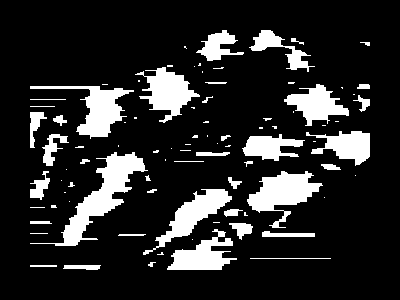

In [74]:
Image.fromarray(map2draw)

In [75]:
len(pairs)

19072

In [76]:
len(rejected_pairs)

62528

In [ ]:
Boundary = 1e-4
bestF = None
bestScore = 0

all_right = np.array([i[1] for i in pairs])
all_left = np.array([i[0] for i in pairs])

for iteration in range(20000):
    seven_pairs = choices(pairs, k=7)
    X_big = []
    for left, right in seven_pairs:
        x_l, y_l, z_l = left
        x_r, y_r, z_r = right
        X_big.append([x_r*x_l, x_r*y_l, x_r*z_l,
                      y_r*x_l, y_r*y_l, y_r*z_l,
                      z_r*x_l, z_r*y_l, z_r*z_l])
        # на попередній лінії була помилка,
        # через яку я декілька тижнів не міг зрозуміти чого не працює.
        # вічна пам'ять моїм загиблим нервовим клітинам.
        # F
    X_big = np.array(X_big)
    null_vectors = null_space(X_big)
    f1 = null_vectors[:,0].reshape((3,3))
    f2 = null_vectors[:,1].reshape((3,3))
    
    p = np.array([
     np.linalg.det(f2),
     np.linalg.det(f2)*np.trace(np.dot(np.linalg.inv(f2), f1)),
     np.linalg.det(f1)*np.trace(np.dot(np.linalg.inv(f1), f2)),
     np.linalg.det(f1),
    # на попередній лінії була помилка,
    # через яку я декілька місяців не міг зрозуміти чого не працює.
    # вічна пам'ять моїм загиблим нервовим клітинам.
    # F
    ])
    coefs = np.roots(p)
    for i in coefs:
        if np.iscomplex(i):
            continue
        F = f1+float(i)*f2
        # both matrix have zero det
        score = np.sum(np.abs(np.einsum('ki,ij,kj->k', all_right, F, all_left)) < Boundary)
        if score > bestScore:
            bestScore = score
            bestF = F.copy()
            print("="*20)
            print("hit", bestScore/len(pairs))
            
            epipole = null_space(bestF, 1e-3)
            print(epipole)
            epipole = epipole/epipole[-1]
            epipole_strich = [epipole[0,0], epipole[1,0]]
            print("X:", epipole_strich[0])
            print("Y:", epipole_strich[1])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:40: ComplexWarning: Casting complex values to real discards the imaginary part


hit 0.00047189597315436244
[[-0.85521725]
 [-0.51824088]
 [-0.00546332]]
X: 156.53807186380303
Y: 94.85827008137115
hit 0.001153523489932886
[[-0.67519917]
 [-0.73762281]
 [-0.00432113]]
X: 156.2553264107229
Y: 170.70147162201246
hit 0.0014156879194630872
[[-0.87268808]
 [-0.48823377]
 [-0.00658005]]
X: 132.62627045400447
Y: 74.19904783788908
hit 0.0028313758389261743
[[-0.13488555]
 [-0.9908568 ]
 [-0.00294762]]
X: 45.7608678078188
Y: 336.15511677192154
hit 0.003355704697986577
[[-0.61446065]
 [-0.78894046]
 [-0.00332596]]
X: 184.74687962399327
Y: 237.20686992020123
hit 0.004037332214765101
[[-0.68548423]
 [-0.72807828]
 [-0.00366023]]
X: 187.2791921989484
Y: 198.91619096647915
hit 0.004614093959731544
[[-0.73531407]
 [-0.67771732]
 [-0.00352818]]
X: 208.41151145725905
Y: 192.08674959179288
hit 0.2648909395973154
[[-4.47213596e-01]
 [-8.94427191e-01]
 [-7.72715225e-14]]
X: 5787560293269.806
Y: 11575120586473.074
hit 0.28083053691275167
[[ 7.07106781e-01]
 [-7.07106781e-01]
 [-4.796163

## Фундаментальна матриця

In [52]:
np.round(bestF, 2)

array([[ 0.  , -0.  ,  0.  ],
       [ 0.  , -0.  , -0.7 ],
       [-0.  ,  0.7 ,  1.41]])

In [53]:
bestF

array([[ 1.01643954e-20, -4.92932518e-16,  1.81687998e-13],
       [ 5.30716963e-16, -2.85136701e-17, -7.03656547e-01],
       [-1.89265270e-13,  7.03656547e-01,  1.40731309e+00]])

In [36]:
np.save("bestF.npy", bestF)
np.save("bestScore.npy", bestScore)

In [37]:
#bestF = np.load("bestF.npy")
#bestScore = np.load("bestScore.npy")

In [38]:
#with shelve.open("lab2.db") as db:
#    #db["bestF"] = bestF
#    #db["bestScore"] = bestScore
#    bestF = db["bestF"]
#    bestScore = db["bestScore"]
#    #img_shift2 = db["img_shift2"]

## Відсоток точок, які задовольняють умову до фундаментальної матриці

In [39]:
print(round(100*bestScore/len(pairs), 2),"%")

45.09 %


## Епіполярна точка у 3-х координатах

In [40]:
epipole = null_space(bestF, 1e-3)
epipole = epipole/epipole[-1]
epipole

array([[2.63733935e+13],
       [7.91201805e+13],
       [1.00000000e+00]])

In [41]:
np.linalg.det(bestF)

2.980300927693907e-20

In [42]:
epipole_strich = [epipole[0,0], epipole[1,0]]

## Епіполярна точка

In [43]:
print("X:", epipole_strich[0])
print("Y:", epipole_strich[1])

X: 26373393503788.66
Y: 79120180510936.88


## Ліве зображення

In [26]:
from PIL import ImageDraw

In [27]:
image2show = Image.open("i1.jpg").resize((400,300), Image.BICUBIC).convert("RGB")
draw = ImageDraw.Draw(image2show)
for i in range(11):
    draw.line((0, i*30, epipole_strich[0], epipole_strich[1]), fill=128)
image2show

KeyboardInterrupt: 

## Праве зображення

In [ ]:
Image.open("i2.jpg").resize((400,300), Image.BICUBIC).convert("RGB")